In [6]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 9.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=47b196f60bfb320d4588588345e3121f44a5fe7f7d3351bb77b87a3c371325e5
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 616kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 2.2MB 44.8MB/s 
     |████████████████████████████████| 645kB 54.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=8fc588506d5ed3b78caf89e1bd41c8eff1de43184c115ec7ab76194eaf923d90
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
  Created wheel for iopath: filename=iopath-0.1.6-cp37-none-any.whl size=18269 sha256=662599b7897bb30fd6f7b563c41096e04ed7442ab0ca329036f65b684e9af05f
  Stored in directory: /root/.cache/pip/wheels/ff/87/55/7513122394822977f993e1798bfebb46730d6183df8db7b283
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Fou

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

In [1]:
cd /content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2

/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2


In [19]:
!ls

ACL_segmentation_data		vid1-output.mkv  vid4.mp4
ACL_seg.mp4			vid1-output.mp4  vid4-output.mp4
detect_from_webcam_or_video.py	vid2.mp4	 vid5.mp4
detectron2			vid2-output.mkv  vid5-output.mp4
output				vid3.mp4	 video-output.mkv
output.avi			vid3-output.mkv
vid1.mp4			vid3-output.mp4


In [ ]:
!ls 'ACL_segmentation_data'

labelme2coco.py  test  test.json  train  train.json


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [20]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"ACL_{d}", {}, f"ACL_segmentation_data/{d}.json", f"ACL_segmentation_data/{d}")

AssertionError: ignored

WARNING [03/19 10:40:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/19 10:40:38 d2.data.datasets.coco]: Loaded 176 images in COCO format from ACL_segmentation_data/train.json


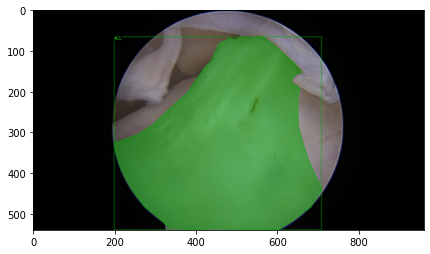

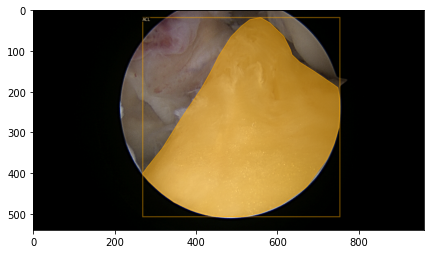

In [21]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("ACL_train")
ACL_metadata = MetadataCatalog.get("ACL_train")

for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=ACL_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (7, 5))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

##Image inference

In [22]:
# Create config
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/output/config.yml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/output/model_0004999.pth"

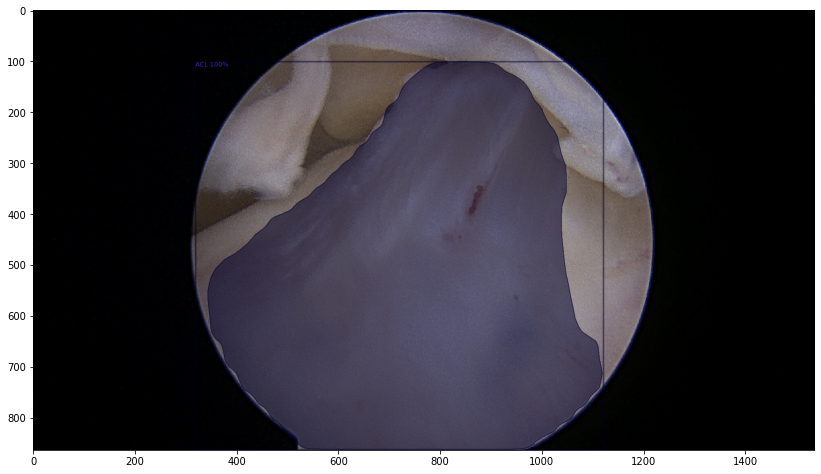

In [23]:
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/ACL_segmentation_data/test/145.jpg")
# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2.imshow(v.get_image()[:, :, ::-1])
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

Metadata(evaluator_type='coco', image_root='ACL_segmentation_data/train', json_file='ACL_segmentation_data/train.json', name='ACL_train', thing_classes=['ACL'], thing_dataset_id_to_contiguous_id={0: 0})

## Video Inference

In [4]:
import logging

In [5]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
#!git clone https://github.com/facebookresearch/detectron2
!python /content/demo.py --config-file output/config.yml --video-input vid5.mp4 --confidence-threshold 0.75 --output vid5-outL.mkv \
  --opts MODEL.WEIGHTS output/model_0004999.pth

Streaming output truncated to the last 5000 lines.
changes iden
 55% 3640/6561 [20:32<16:51,  2.89it/s]['ACL 99%', 'ACL 97%']
changes iden
 55% 3641/6561 [20:33<17:09,  2.84it/s]['ACL 96%', 'ACL 93%']
changes iden
 56% 3642/6561 [20:33<17:20,  2.80it/s]['ACL 90%']
changes iden
 56% 3643/6561 [20:33<17:00,  2.86it/s]['ACL 88%']
changes iden
 56% 3644/6561 [20:34<16:57,  2.87it/s]['ACL 83%']
changes iden
 56% 3646/6561 [20:34<16:16,  2.99it/s]['ACL 85%']
changes iden
 56% 3647/6561 [20:35<16:37,  2.92it/s]['ACL 87%']
changes iden
 56% 3648/6561 [20:35<16:44,  2.90it/s]['ACL 90%']
changes iden
 56% 3649/6561 [20:35<16:47,  2.89it/s]['ACL 80%']
changes iden
 56% 3650/6561 [20:36<16:39,  2.91it/s]['ACL 88%', 'ACL 75%']
changes iden
 56% 3651/6561 [20:36<16:58,  2.86it/s]['ACL 95%']
changes iden
 56% 3652/6561 [20:36<16:55,  2.86it/s]['ACL 78%']
changes iden
 56% 3654/6561 [20:37<16:25,  2.95it/s]['ACL 76%']
changes iden
 56% 3655/6561 [20:37<16:28,  2.94it/s]['ACL 80%']
changes iden
 56% 36

## Video inference_v2
Gilbert Tanner

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75

In [ ]:
#!pip uninstall -y opencv-python-headless opencv-contrib-python
#!apt install python3-opencv  # the one pre-installed have some issues

Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-numpy python3-opencv
0 upgraded, 2 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,477 kB of archives.
After this operation, 13.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 2,477 kB in 3s (952 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../pytho

In [ ]:
input_vid = "/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/vid3.mp4"
output_vid = "/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/vid3_out.mp4"
cap = cv2.VideoCapture(input_vid)
show = False

if not cap.isOpened():
  print("Error opening video stream or file")

   
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(output_vid, cv2.VideoWriter_fourcc(*"MPEG"), frames_per_second, (width, height))
        
while cap.isOpened():
    ret, image = cap.read()
    
    outputs = predictor(image)

    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    if show:
        cv2_imshow('object_detection', v.get_image()[:, :, ::-1])
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    
    if output_vid:
        out.write(image)
cap.release()
if output_vid:
    out.release()
cv2.destroyAllWindows()

AttributeError: ignored

In [ ]:
ls

ACL_segmentation_data/          vid1-output.mp4  vid4.mp4
ACL_seg.mp4                     vid2.mp4         vid4-output.mp4
detect_from_webcam_or_video.py  vid2-output.mkv  vid5.mp4
detectron2/                     vid3.mp4         vid5-output.mp4
output/                         vid3_out.mp4     video-output.mkv
vid1.mp4                        vid3-output.mkv
vid1-output.mkv                 vid3-output.mp4


In [ ]:
input_vid = "/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/vid3.mp4"
output_vid = "/content/drive/MyDrive/Colab Notebooks/ACL_segmentation/Detectron2/vid3_out.mp4"
cap = cv2.VideoCapture(input_vid)
show = False

if not cap.isOpened():
  print("Error opening video stream or file")

   
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(output_vid, cv2.VideoWriter_fourcc(*"MPEG"), frames_per_second, (width, height))
        
while cap.isOpened():
    ret, image = cap.read()
plt.imshow(image)
plt.show()

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('vid1.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
#out = cv2.VideoWriter('vid1_oo.mp4', cv2.VideoWriter_fourcc(*"MPEG"), frames_per_second, (width, height))
while(cap.isOpened()):
    ret, frame = cap.read()

    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    outputs = predictor(frame)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    out.write(v.get_image()[:, :, ::-1])
    #cv2_imshow(gray)
    cv2_imshow(v.get_image()[:, :, ::-1])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
#out.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
%ls

ACL_segmentation_data/          vid1-output.mkv  vid4.mp4
ACL_seg.mp4                     vid1-output.mp4  vid4-output.mp4
detect_from_webcam_or_video.py  vid2.mp4         vid5.mp4
detectron2/                     vid2-output.mkv  vid5-output.mp4
output/                         vid3.mp4         video-output.mkv
output.avi                      vid3-output.mkv
vid1.mp4                        vid3-output.mp4


In [29]:
import numpy as np
import cv2

cap = cv2.VideoCapture('vid1.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"MPEG")
out = cv2.VideoWriter('output.mkv',fourcc, 20.0, (640,480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,0)

        # write the flipped frame
        out.write(frame)

        #cv2_imshow(frame)
        #if cv2.waitKey(1) & 0xFF == ord('q'):
         #   break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()